<a href="https://colab.research.google.com/github/levyashvin/software-salary-prediction/blob/main/Software_Salary_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Software salary prediction using machine learning
### By Yuva Yashvin, Yuvan Bharathi, Ritvik Marwah

#### dataset link [here](https://www.kaggle.com/datasets/iamsouravbanerjee/software-professional-salaries-2022)

In [2]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00


In [3]:
# loading neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from category_encoders.target_encoder import TargetEncoder
from scipy import sparse
# from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')
import pickle

In [4]:
# loading dataset from kaggle directly
from google.colab import userdata
import os

# Set the Kaggle API key and username as environment variables
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

!pip install kaggle
!kaggle datasets download -d iamsouravbanerjee/software-professional-salaries-2022
!unzip software-professional-salaries-2022.zip

Dataset URL: https://www.kaggle.com/datasets/iamsouravbanerjee/software-professional-salaries-2022
License(s): other
  0% 0.00/526k [00:00<?, ?B/s]
100% 526k/526k [00:00<00:00, 1.21GB/s]
Archive:  software-professional-salaries-2022.zip
  inflating: Salary_Dataset_with_Extra_Features.csv  
  inflating: Software_Professional_Salaries.csv  
  inflating: Types of Different Job Profiles.txt  


In [5]:
df = pd.read_csv('Salary_Dataset_with_Extra_Features.csv')

df.head()

,Rating,Company Name,Job Title,Salary,Salaries Reported,Location,Employment Status,Job Roles
0,3.8,Sasken,Android Developer,400000,3,Bangalore,Full Time,Android
1,4.5,Advanced Millennium Technologies,Android Developer,400000,3,Bangalore,Full Time,Android
2,4.0,Unacademy,Android Developer,1000000,3,Bangalore,Full Time,Android
3,3.8,SnapBizz Cloudtech,Android Developer,300000,3,Bangalore,Full Time,Android
4,4.4,Appoids Tech Solutions,Android Developer,600000,3,Bangalore,Full Time,Android


## Data Preparation

In [ ]:
# dataset shape
print(f'shape: {df.shape}\n')

shape: (22770, 8)



In [ ]:
print('dataframe info:')
print(f'{df.info()}\n')

dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22770 entries, 0 to 22769
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rating             22770 non-null  float64
 1   Company Name       22769 non-null  object 
 2   Job Title          22770 non-null  object 
 3   Salary             22770 non-null  int64  
 4   Salaries Reported  22770 non-null  int64  
 5   Location           22770 non-null  object 
 6   Employment Status  22770 non-null  object 
 7   Job Roles          22770 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 1.4+ MB
None



In [ ]:
# null values
df.isnull().sum()

,0
Rating,0
Company Name,1
Job Title,0
Salary,0
Salaries Reported,0
Location,0
Employment Status,0
Job Roles,0


In [ ]:
# one missing company name
df[df['Company Name'].isnull()]

,Rating,Company Name,Job Title,Salary,Salaries Reported,Location,Employment Status,Job Roles
13760,4.0,NaN,Software Development Engineer,1188000,1,Bangalore,Full Time,SDE


In [6]:
# since it has only on reported salary we can drop it
df.dropna(inplace=True)

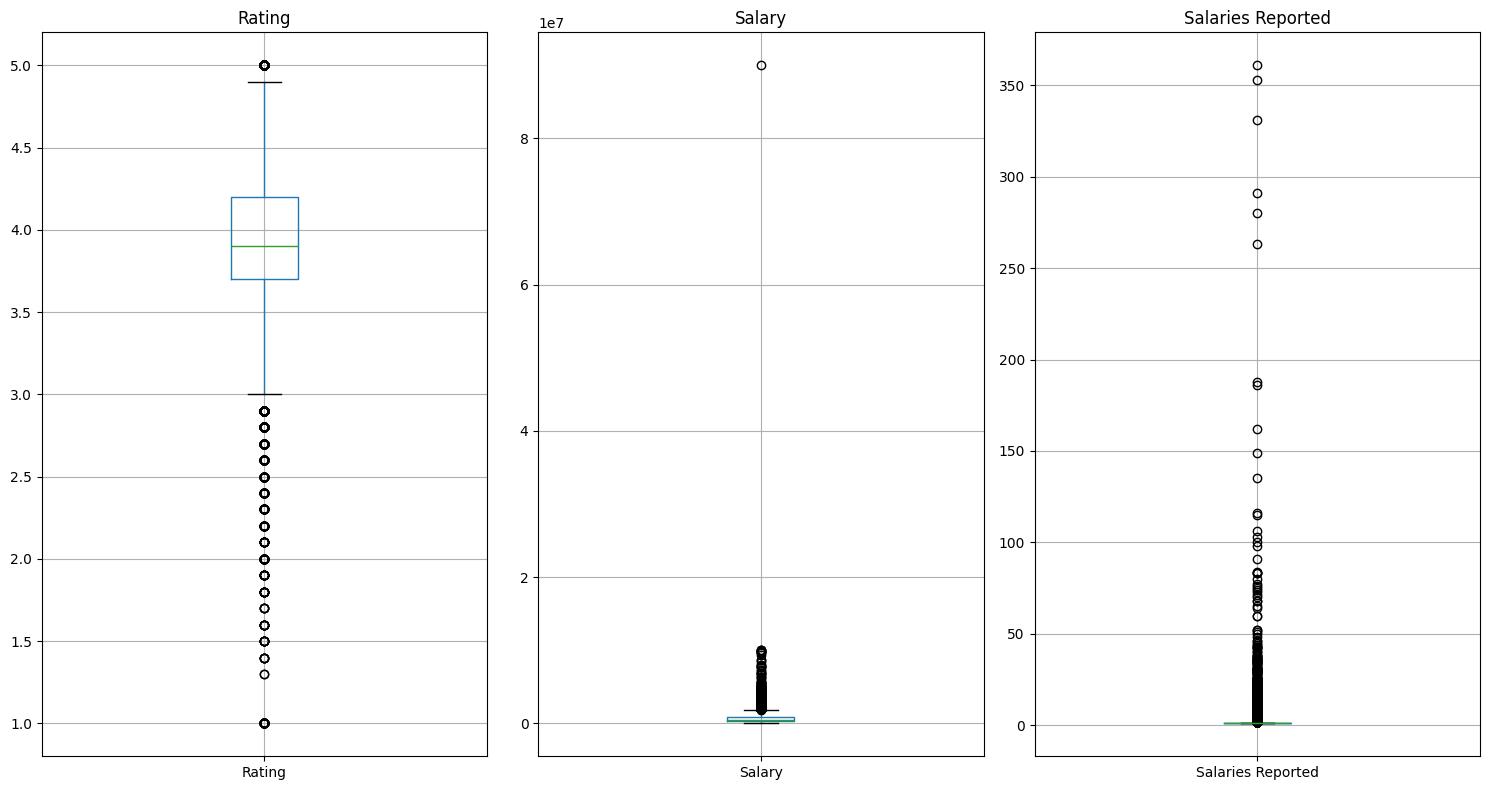

In [ ]:
# checking for abnormalities in dataset
numerical_cols = ['Rating', 'Salary', 'Salaries Reported']
cols = df.loc[:,numerical_cols]
n = 3

# creating subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))

# flattening axes array for easy indexing
axes = axes.flatten()

for i, col in enumerate(cols):
    df[[col]].boxplot(ax=axes[i])
    axes[i].set_title(col)

# hiding last unused axis
#axes[i+1].set_visible(False)

plt.tight_layout()
plt.show()

## Out of the columns we need to worry about Salary as one datapoint looks off.

In [ ]:
df[df['Salary'] == max(df['Salary'])]

,Rating,Company Name,Job Title,Salary,Salaries Reported,Location,Employment Status,Job Roles
18635,3.6,Thapar University,Software Development Engineer (SDE),90000000,1,New Delhi,Full Time,SDE


In [7]:
df.drop(df[df['Salary'] == max(df['Salary'])].index, inplace=True)

## Exploratory Data Analysis

In [ ]:
# descriptive statistics on the numerical data
df.describe()

,Rating,Salary,Salaries Reported
count,22768.000000,2.276800e+04,22768.000000
mean,3.918223,6.914432e+05,1.855850
std,0.519694,6.571930e+05,6.823963
min,1.000000,2.112000e+03,1.000000
25%,3.700000,3.000000e+05,1.000000
50%,3.900000,5.000000e+05,1.000000
75%,4.200000,9.000000e+05,1.000000
max,5.000000,1.000000e+07,361.000000


In [ ]:
# same for categorical columns
df.describe(include=['object','bool'])

,Company Name,Job Title,Location,Employment Status,Job Roles
count,22768,22768,22768,22768,22768
unique,11259,1080,10,4,11
top,Tata Consultancy Services,Software Development Engineer,Bangalore,Full Time,SDE
freq,271,2350,8263,20081,8181


In [ ]:
# Grouped summaries
# Filter out companies with only one entry otherwise std will result in NaN
df_filtered = df.groupby('Company Name').filter(lambda x: len(x) > 1)

# Recalculate the company-wise summary
company_wise_summary_filtered = df_filtered.groupby('Company Name').agg({
    'Salary': ['mean', 'median', 'std', 'min', 'max'],
    'Rating': ['mean', 'median', 'std', 'min', 'max'],
})

company_wise_summary_filtered

Salary                          \
                                          mean    median           std   
Company Name                                                             
(no)name                         869666.666667  469000.0  9.767214e+05   
-                                500000.000000  500000.0  5.656854e+05   
.Kreate                          290000.000000  290000.0  1.555635e+05   
10Decoders Consultancy Services  144000.000000  132000.0  3.174902e+04   
1Gen                             444000.000000  444000.0  2.206173e+05   
...                                        ...       ...           ...   
ubiqtas technologies             850000.000000  850000.0  3.535534e+05   
udaan.com                        962000.000000  962000.0  1.326532e+06   
upGrad                           906000.000000  906000.0  8.400429e+05   
yellow.ai                        530400.000000  400000.0  4.912238e+05   
zCon Solutions                   330000.000000  330000.0  4.242641e+04   

                                                 Rating                        \
                                    min      max   mean median       std  min   
Company Name                                                                    
(no)name                         180000  2700000   4.00   4.00  0.000000  4.0   
-                                100000   900000   3.95   3.95  0.070711  3.9   
.Kreate                          180000   400000   4.50   4.50  0.000000  4.5   
10Decoders Consultancy Services  120000   180000   4.30   4.30  0.000000  4.3   
1Gen                             288000   600000   4.80   4.80  0.000000  4.8   
...                                 ...      ...    ...    ...       ...  ...   
ubiqtas technologies             600000  1100000   4.50   4.50  0.000000  4.5   
udaan.com                         24000  1900000   3.90   3.90  0.000000  3.9   
upGrad                           312000  1500000   3.60   3.60  0.000000  3.6   
yellow.ai                        120000  1300000   4.30   4.30  0.000000  4.3   
zCon Solutions                   300000   360000   3.80   3.80  0.000000  3.8   

                                      
                                 max  
Company Name                          
(no)name                         4.0  
-                                4.0  
.Kreate                          4.5  
10Decoders Consultancy Services  4.3  
1Gen                             4.8  
...                              ...  
ubiqtas technologies             4.5  
udaan.com                        3.9  
upGrad                           3.6  
yellow.ai                        4.3  
zCon Solutions                   3.8  

[2980 rows x 10 columns]

In [ ]:
# Job wise summaries
job_role_wise_summary = df.groupby('Job Roles').agg({
    'Salary': ['mean', 'median', 'std', 'min', 'max'],
    'Rating': ['mean', 'median', 'std', 'min', 'max'],
})

job_role_wise_summary

Salary                                              Rating  \
                    mean    median           std     min       max      mean   
Job Roles                                                                      
Android    565911.003056  400000.0  5.303402e+05   12000   7100000  3.893141   
Backend    748518.164154  500000.0  7.277008e+05   24000   5200000  4.016750   
Database   958584.046243  700000.0  8.153262e+05  100000  10000000  3.825780   
Frontend   610098.699954  420000.0  6.136750e+05   12000  10000000  3.958784   
IOS        695254.248927  588000.0  5.282906e+05   12000   5200000  3.905303   
Java       564709.907427  400000.0  6.054523e+05    8448  10000000  3.849892   
Mobile     882282.971429  600000.0  1.023473e+06   60000   9600000  3.976327   
Python     486022.791975  400000.0  4.233985e+05   24000   6900000  3.965259   
SDE        842856.933871  660000.0  7.406655e+05   12000   9850000  3.939800   
Testing    496298.188506  400000.0  3.961338e+05   12672   6600000  3.828276   
Web        415451.947948  300000.0  3.590405e+05    2112   4400000  3.935936   

                                      
          median       std  min  max  
Job Roles                             
Android      4.0  0.622397  1.0  5.0  
Backend      4.0  0.572186  1.0  5.0  
Database     3.8  0.391896  1.0  5.0  
Frontend     4.0  0.566050  1.0  5.0  
IOS          4.0  0.585595  1.0  5.0  
Java         3.9  0.474126  1.0  5.0  
Mobile       4.0  0.559943  1.0  5.0  
Python       4.0  0.559945  1.0  5.0  
SDE          4.0  0.440194  1.0  5.0  
Testing      3.9  0.476648  1.0  5.0  
Web          4.0  0.639686  1.0  5.0

In [ ]:
location_wise_summary = df.groupby('Location').agg({
    'Salary': ['mean', 'median', 'std', 'min', 'max'],
    'Rating': ['mean', 'median', 'std', 'min', 'max'],
})

location_wise_summary

Salary                                           \
                         mean    median           std    min       max   
Location                                                                 
Bangalore       735289.958611  500000.0  6.838601e+05   2112  10000000   
Chennai         584559.661513  400000.0  5.435952e+05  12000  10000000   
Hyderabad       679099.157376  500000.0  6.651821e+05   8448   9700000   
Jaipur          629135.802469  500000.0  4.755495e+05  36000   2500000   
Kerala          553577.481481  500000.0  4.046759e+05  72000   2900000   
Kolkata         710925.573034  500000.0  8.849003e+05  60000   9850000   
Madhya Pradesh  677641.909677  500000.0  1.008579e+06  96000   7800000   
Mumbai          961180.368491  708000.0  8.446357e+05  12000   9800000   
New Delhi       637357.635449  500000.0  5.599286e+05  12000   9800000   
Pune            690476.311153  500000.0  6.779073e+05  23232  10000000   

                  Rating                             
                    mean median       std  min  max  
Location                                             
Bangalore       3.920223    4.0  0.534826  1.0  5.0  
Chennai         3.902726    3.9  0.475373  1.0  5.0  
Hyderabad       3.914484    3.9  0.502500  1.0  5.0  
Jaipur          3.940741    4.0  0.505662  2.6  5.0  
Kerala          3.885185    3.9  0.535438  2.5  5.0  
Kolkata         4.024719    4.0  0.476873  1.0  5.0  
Madhya Pradesh  3.992258    3.9  0.420503  2.6  5.0  
Mumbai          3.881709    3.9  0.468328  1.6  5.0  
New Delhi       3.943497    4.0  0.543944  1.0  5.0  
Pune            3.886082    3.9  0.519445  1.0  5.0

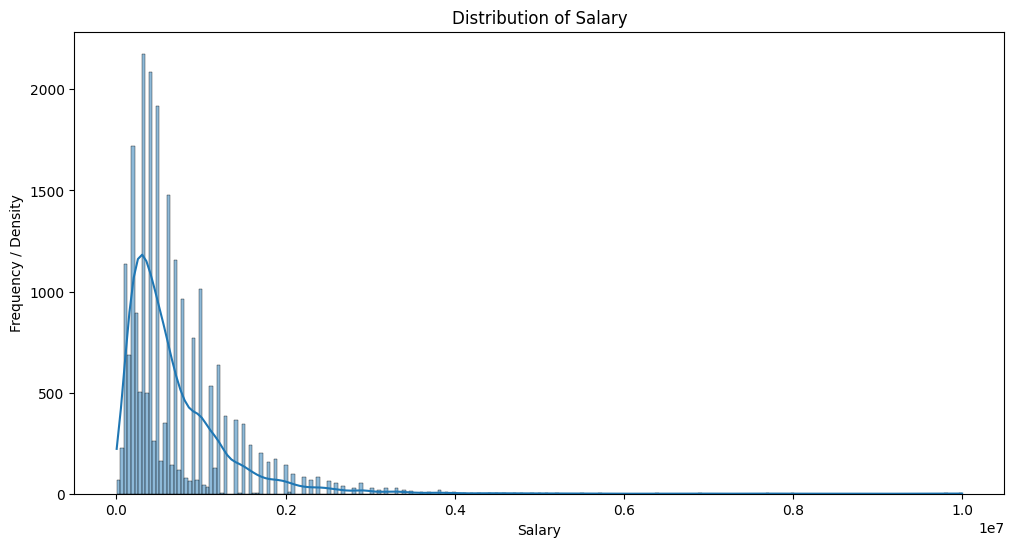

In [ ]:
# Univariate analysis

# Plot histogram with KDE for 'Salary'
plt.figure(figsize=(12, 6))
sns.histplot(df['Salary'], kde=True)
plt.title('Distribution of Salary')
plt.xlabel('Salary')
plt.ylabel('Frequency / Density')
plt.show()

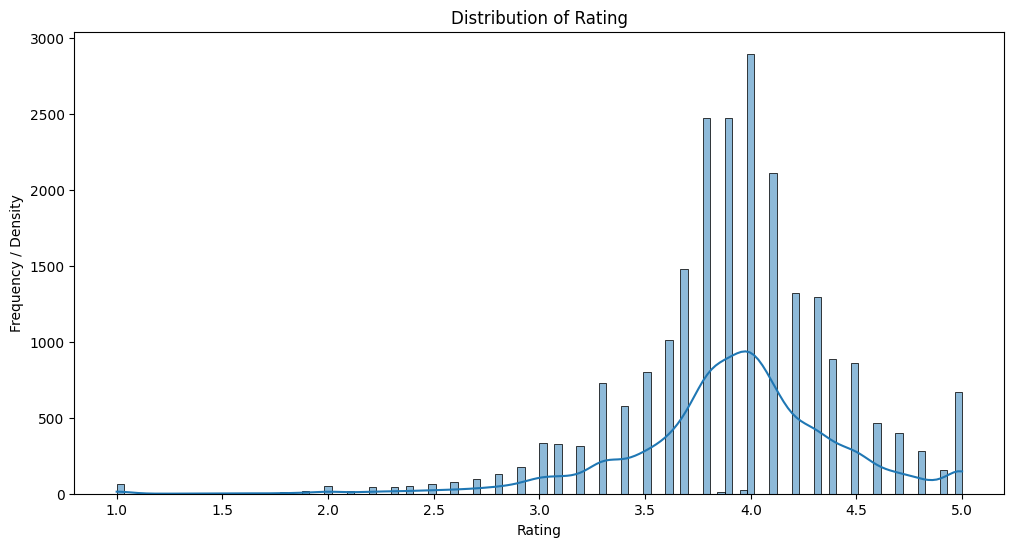

In [ ]:
plt.figure(figsize=(12, 6))

# Plot histogram with KDE for 'Rating'
sns.histplot(df['Rating'], kde=True)
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency / Density')
plt.show()

In [ ]:
# Get frequency counts of each job role
job_roles = df['Job Roles'].value_counts()

# Create a bar chart using Plotly Express
fig = px.bar(
    x=job_roles.index,
    y=job_roles.values,
    color=job_roles.index,
    color_discrete_sequence=px.colors.sequential.PuBuGn,
    text=job_roles.values,
    title='Job Roles Distribution',
    template='plotly_dark',
    width=1000,
    height=500
)

# Show the chart
fig.show()

In [ ]:
Rating = df['Rating'].value_counts()
# Create a bar chart with x-axis as unique values in Rating column, y-axis as their count and color of the bars based on the unique values
fig = px.bar(y=Rating.values,
             x=Rating.index,
             color = Rating.index,
             color_discrete_sequence=px.colors.sequential.PuBuGn,
             text=Rating.values,
             title= 'Rating distribution',
             template= 'plotly_dark',
             width=1000, height=500)

# Show the chart
fig.show()

In [ ]:
# Calculate the mean salary for each job role and round it off to the nearest integer
mean=pd.DataFrame(df.groupby("Job Roles")["Salary"].mean().round(0)).reset_index()

# Create a bar plot with job roles on the x-axis and mean salary on the y-axis
fig = px.bar(y=mean["Salary"],
             x=mean["Job Roles"],
             color = mean["Job Roles"],
             color_discrete_sequence=px.colors.sequential.PuBuGn,
             text=mean["Salary"],
             title= 'Job roles and average salary',
             template= 'plotly_dark',
             width=1000, height=500)

# Show the chart
fig.show()

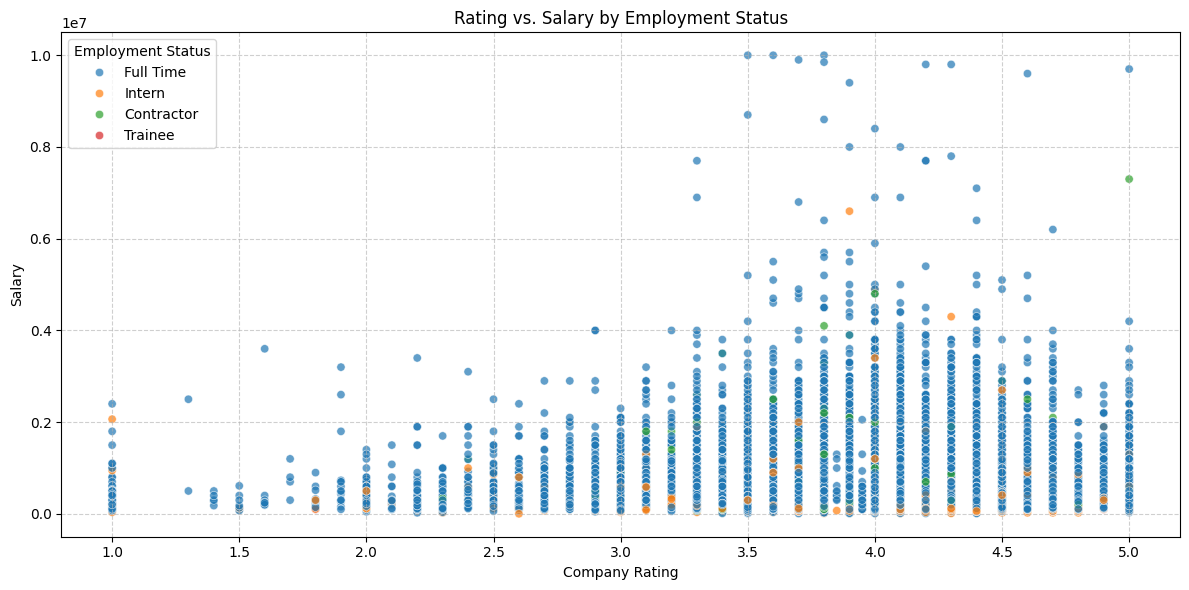

In [ ]:
# Bivariate analysis
# Scatter Plot: Rating vs Salary (Numerical vs Numerical)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Rating', y='Salary', hue='Employment Status', data=df, alpha=0.7)
plt.title('Rating vs. Salary by Employment Status')
plt.xlabel('Company Rating')
plt.ylabel('Salary')
plt.legend(title='Employment Status')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

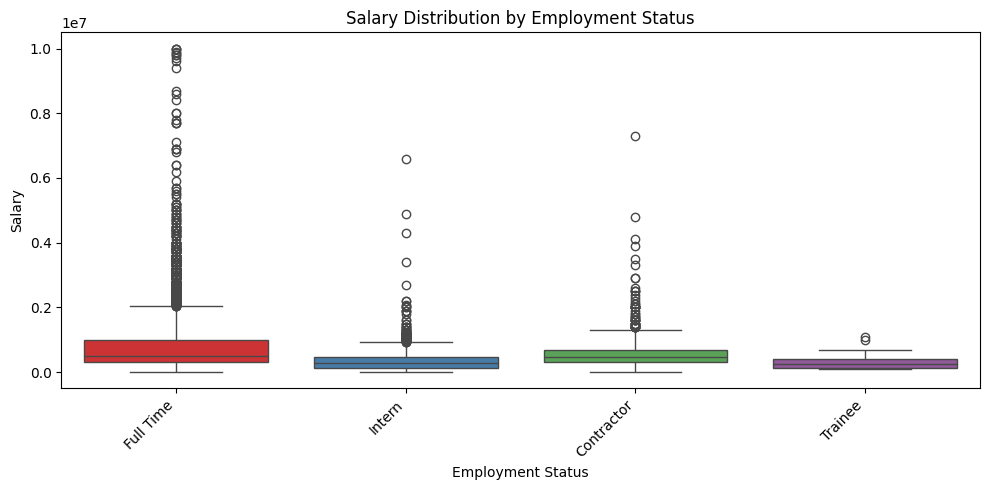

In [ ]:
# Box Plot: Salary by Employment Status (Numerical vs Categorical)
plt.figure(figsize=(10, 5))
sns.boxplot(x='Employment Status', y='Salary', data=df, palette='Set1')
plt.title('Salary Distribution by Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Salary')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

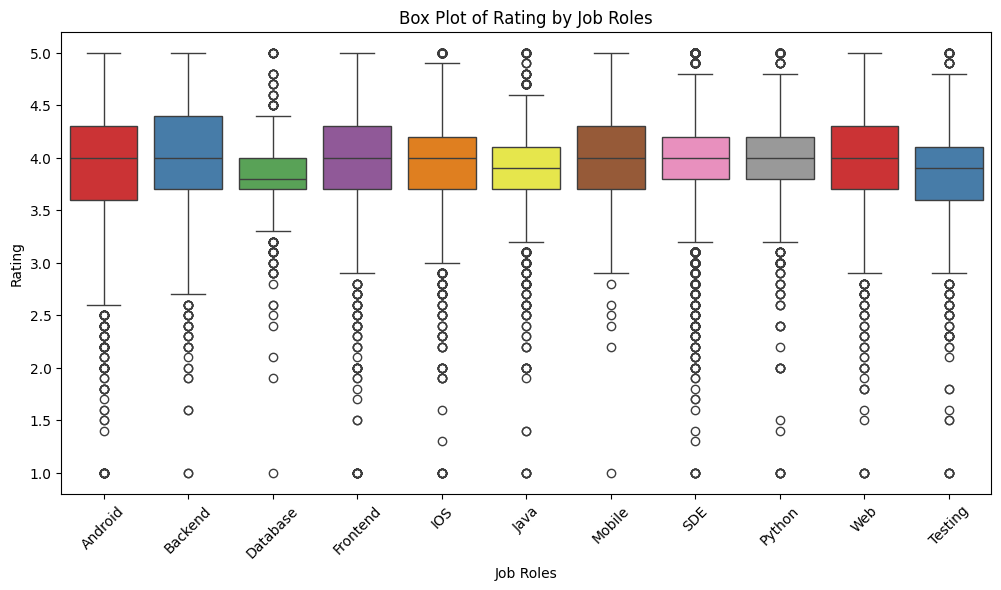

In [ ]:
# Plot box plot of 'Rating' grouped by 'Job Roles'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Job Roles', y='Rating', data=df, palette='Set1')
plt.title('Box Plot of Rating by Job Roles')
plt.xlabel('Job Roles')
plt.ylabel('Rating')
plt.xticks(rotation=45)  # Rotate x labels for better readability, if necessary
plt.show()

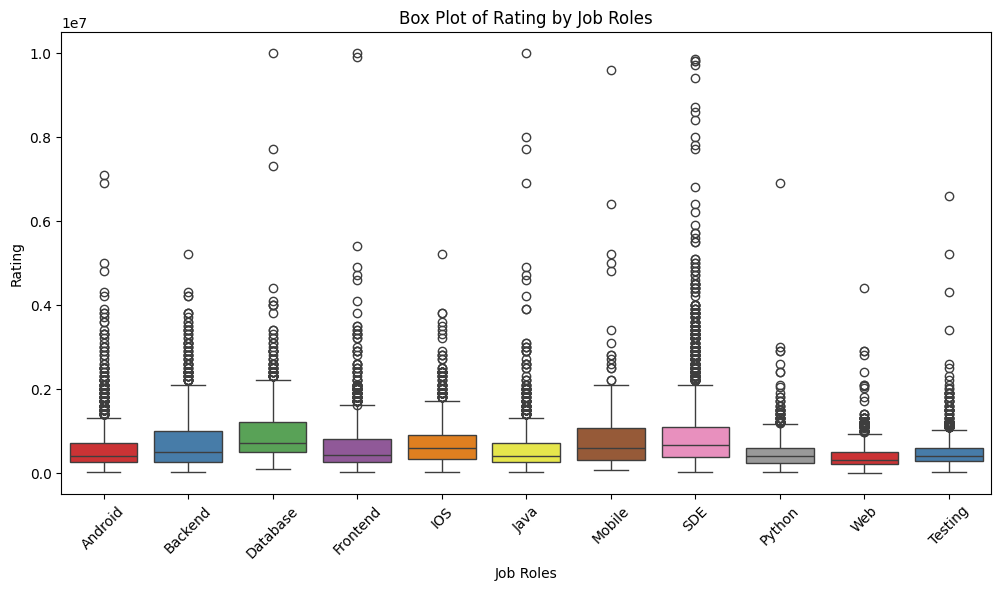

In [ ]:
# Set figure size
plt.figure(figsize=(12, 6))

# Plot box plot of 'Rating' grouped by 'Job Roles'
sns.boxplot(x='Job Roles', y='Salary', data=df, palette='Set1')
plt.title('Box Plot of Rating by Job Roles')
plt.xlabel('Job Roles')
plt.ylabel('Rating')
plt.xticks(rotation=45)  # Rotate x labels for better readability, if necessary
plt.show()


<Figure size 1000x800 with 0 Axes>

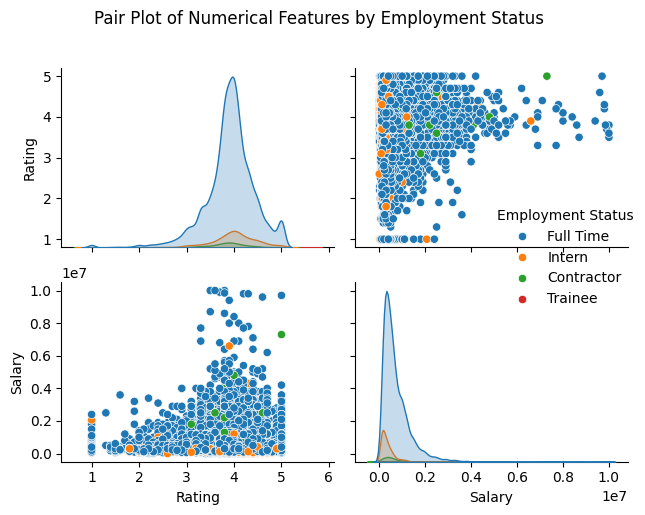

In [ ]:
# Multivariate plots

# Pair Plot of Numerical Features with Employment Status as Hue
numerical_features = ['Rating', 'Salary']
plt.figure(figsize=(10, 8))  # Adjust width and height as needed

numerical_features = ['Rating', 'Salary']
sns.pairplot(df[numerical_features + ['Employment Status']], hue='Employment Status', diag_kind='kde')
plt.suptitle('Pair Plot of Numerical Features by Employment Status', y=1.02)
plt.tight_layout()
plt.show()

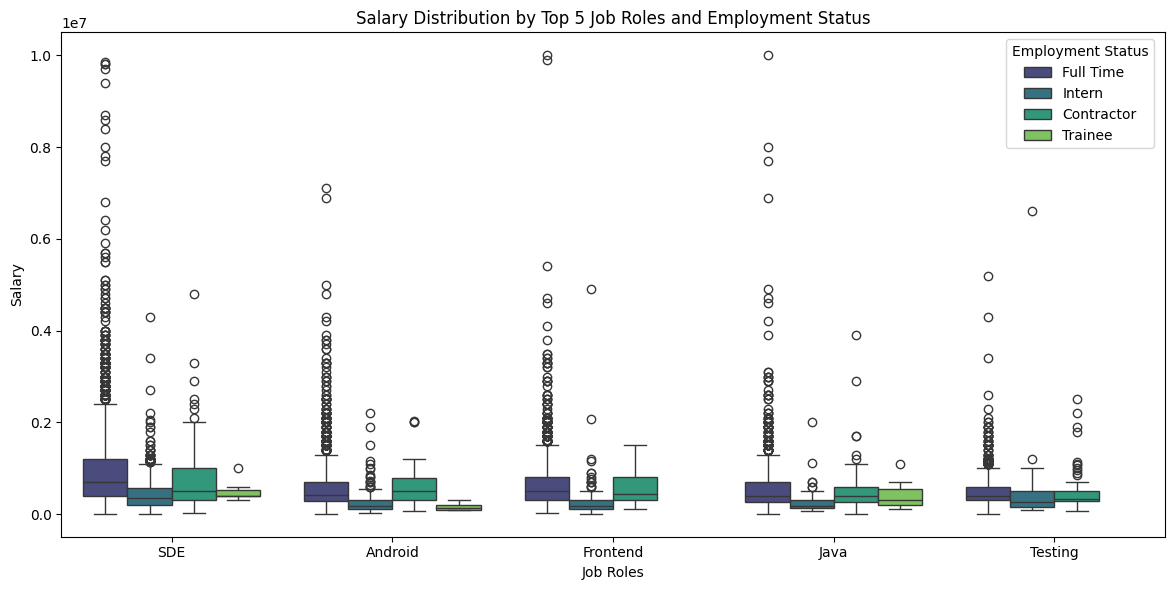

In [ ]:
top_5_job_roles = df['Job Roles'].value_counts().nlargest(5).index
df_top_5_job_roles = df[df['Job Roles'].isin(top_5_job_roles)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='Job Roles', y='Salary', hue='Employment Status', data=df_top_5_job_roles,
            order=top_5_job_roles, palette='viridis')
plt.title('Salary Distribution by Top 5 Job Roles and Employment Status')
plt.xlabel('Job Roles')
plt.ylabel('Salary')
plt.legend(title='Employment Status', bbox_to_anchor=(0.85, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Model Bulding

In [ ]:
# We will keep the original dataframe for reference and work with a copy
X = df.drop(columns=['Salary'])
y = df['Salary']  # Directly use the original 'Salary' column as target

for col in ['Company Name', 'Job Title']:
    # Calculate the frequency of each category
    counts = X[col].value_counts()
    # Identify categories that appear less than a certain threshold (e.g., 10 times)
    repl = counts[counts < 10].index
    # Replace these rare categories with 'Other'
    X[col] = X[col].replace(repl, 'Other')
    print(f"Reduced unique values in '{col}' from {len(counts)} to {X[col].nunique()}.")

Reduced unique values in 'Company Name' from 11259 to 235.
Reduced unique values in 'Job Title' from 1080 to 155.


In [ ]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

print(f"Categorical Features: {list(categorical_features)}")
print(f"Numerical Features: {list(numerical_features)}")

Categorical Features: ['Company Name', 'Job Title', 'Location', 'Employment Status', 'Job Roles']
Numerical Features: ['Rating', 'Salaries Reported']


In [ ]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1)
}

In [ ]:
list(X_train.columns)

['Rating',
 'Company Name',
 'Job Title',
 'Salaries Reported',
 'Location',
 'Employment Status',
 'Job Roles']

In [ ]:
results = {}

for name, model in models.items():
    print(f"--- Training {name} ---")

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])

    # Train on the original target (no log transformation)
    pipeline.fit(X_train, y_train)

    # Predict using the model
    y_pred = pipeline.predict(X_test)

    # Handle potential negative predictions from the model before evaluation
    y_pred[y_pred < 0] = 0

    # Evaluate using the original, untransformed test data
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r2}
    print(f"Training for {name} complete.\n")

--- Training Linear Regression ---
Training for Linear Regression complete.

--- Training Decision Tree ---
Training for Decision Tree complete.

--- Training Random Forest ---
Training for Random Forest complete.

--- Training XGBoost ---
Training for XGBoost complete.



In [ ]:
print("MODEL EVALUATION RESULTS:\n")

results_df = pd.DataFrame(results).T
print(results_df)

MODEL EVALUATION RESULTS:

                             MAE           MSE           RMSE  R2 Score
Linear Regression  356296.465472  2.906611e+11  539129.960212  0.236872
Decision Tree      426011.586181  4.940911e+11  702916.111763 -0.297232
Random Forest      378252.372280  3.482549e+11  590131.294422  0.085660
XGBoost            351162.281250  2.879340e+11  536594.808831  0.244032


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor   # make sure you have xgboost >= 2.0 installed

# --- 8. Hyperparameter Tuning for XGBoost (Fast Grid Search) ---
print("\n--- Hyperparameter Tuning for XGBoost (Grid Search) ---")

# ⚡ Short, targeted grid (2 × 2 × 2 × 2 = 16 fits × 3-fold CV = 48 model fits)
param_grid = {
    'regressor__n_estimators':   [600, 750],      # around the sweet spot but narrower
    'regressor__max_depth':      [3, 4],          # very small trees vs. slightly deeper
    'regressor__learning_rate':  [0.10, 0.15],    # conservative vs. moderate
    'regressor__subsample':      [0.9, 1.0]       # slight row sampling vs. full data
}

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        random_state=42,
        n_jobs=-1,             # use all CPU cores available
        colsample_bytree=0.6,  # fixed values that worked well before
        gamma=0.0,
        min_child_weight=1,
        reg_alpha=0.1,
        reg_lambda=2.0,
    ))
])

grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid,
    cv=3,              # fewer CV folds → faster, still enough for a signal
    scoring='r2',
    n_jobs=-1,         # parallelise across parameter combos *and* folds
    verbose=2
)

grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")

# Evaluate on the test set
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_pred_xgb[y_pred_xgb < 0] = 0                # clip negatives if salary/price target
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"R2 Score on test set with best XGBoost (Grid Search): {r2_xgb:.4f}")



--- Hyperparameter Tuning for XGBoost (Grid Search) ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__n_estimators': 750, 'regressor__subsample': 1.0}
R2 Score on test set with best XGBoost (Grid Search): 0.2513


In [ ]:
print("\n--- Training Final XGBoost Model with Best Parameters ---")

final_xgb_params = {
    'n_estimators': 400,
    'max_depth': 3,
    'learning_rate': 0.15,
    'subsample': 0.8,
    'colsample_bytree': 0.5,
    'gamma': 0.05,
    'min_child_weight': 5,
    'random_state': 42,
    'n_jobs': -1
}

final_xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(**final_xgb_params))
])

final_xgb_pipeline.fit(X_train, y_train)

# Predict and evaluate
final_y_pred = final_xgb_pipeline.predict(X_test)
final_y_pred[final_y_pred < 0] = 0
final_mae = mean_absolute_error(y_test, final_y_pred)
final_mse = mean_squared_error(y_test, final_y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, final_y_pred)

print(f"Final XGBoost Model Results:")
print(f"MAE: {final_mae:.4f}")
print(f"MSE: {final_mse:.4f}")
print(f"RMSE: {final_rmse:.4f}")
print(f"R2 Score: {final_r2:.4f}")


--- Training Final XGBoost Model with Best Parameters ---
Final XGBoost Model Results:
MAE: 349636.6250
MSE: 283920957440.0000
RMSE: 532842.3383
R2 Score: 0.2546


## Saving the model

In [ ]:
with open('Software Industry Salary Prediction.pkl', 'wb') as file:
    pickle.dump(final_xgb_pipeline, file)

## Trying an alternate model with catgorical values

In [20]:
# Since our data is mainly categoriacl using it to predict categorical is going to perform better
# Making salary bands using bins and using that a our value to predict

# convert to lakh for clarity (optional)
df["Salary_Lakh"] = df["Salary"] / 100_000

# cut-points in lakh rupees
bins   = [0, 3, 6, 10, 15, 25, np.inf]
labels = ["0-3L", "3-6L", "6-10L", "10-15L", "15-25L", "25L+"]

df["Salary_Band"] = pd.cut(
    df["Salary_Lakh"],
    bins=bins,
    labels=labels,
    right=False,       # 0-3  means ≥0 and <3
    include_lowest=True
)

# optional: drop raw salary if you're only classifying
# df = df.drop(columns=["Salary"])

print(df["Salary_Band"].value_counts())


Salary_Band
3-6L      7452
0-3L      5233
6-10L     4880
10-15L    3103
15-25L    1603
25L+       497
Name: count, dtype: int64


In [10]:
# Viewing the newly created columns
df.head()

,Rating,Company Name,Job Title,Salary,Salaries Reported,Location,Employment Status,Job Roles,Salary_Lakh,Salary_Band
0,3.8,Sasken,Android Developer,400000,3,Bangalore,Full Time,Android,4.0,3-6L
1,4.5,Advanced Millennium Technologies,Android Developer,400000,3,Bangalore,Full Time,Android,4.0,3-6L
2,4.0,Unacademy,Android Developer,1000000,3,Bangalore,Full Time,Android,10.0,10-15L
3,3.8,SnapBizz Cloudtech,Android Developer,300000,3,Bangalore,Full Time,Android,3.0,3-6L
4,4.4,Appoids Tech Solutions,Android Developer,600000,3,Bangalore,Full Time,Android,6.0,6-10L


0:	learn: 1.7798779	test: 1.7793835	best: 1.7793835 (0)	total: 282ms	remaining: 18m 45s
200:	learn: 1.4253755	test: 1.4649193	best: 1.4649193 (200)	total: 1m 17s	remaining: 24m 21s
400:	learn: 1.3491666	test: 1.4484817	best: 1.4484817 (400)	total: 2m 44s	remaining: 24m 32s
600:	learn: 1.2860101	test: 1.4434198	best: 1.4433513 (599)	total: 4m 18s	remaining: 24m 24s
800:	learn: 1.2321061	test: 1.4449044	best: 1.4432789 (603)	total: 5m 32s	remaining: 22m 6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 1.443278941
bestIteration = 603

Shrink model to first 604 iterations.
              precision    recall  f1-score   support

        0-3L      0.531     0.413     0.464      1047
      10-15L      0.282     0.277     0.280       621
      15-25L      0.296     0.318     0.306       321
        25L+      0.413     0.263     0.321        99
        3-6L      0.458     0.566     0.506      1490
       6-10L      0.321     0.289     0.304       976

    accuracy           

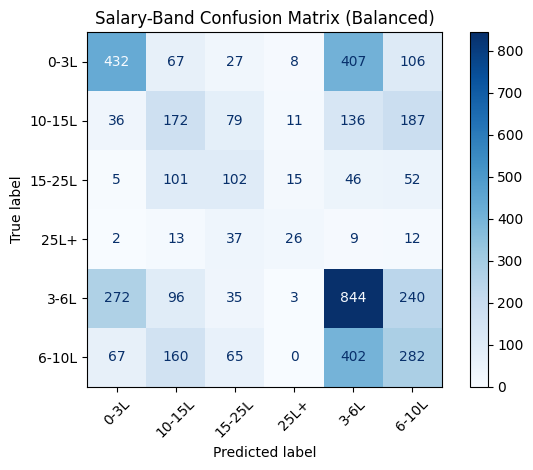

In [19]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1.  Train / test split  (unchanged)
# ------------------------------------------------
cat_cols = ["Company Name", "Job Title", "Location",
            "Employment Status", "Job Roles"]

X = df.drop(columns=["Salary", "Salary_Lakh", "Salary_Band"])  # features
y = df["Salary_Band"]

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

train_pool = Pool(X_tr, y_tr, cat_features=cat_cols)
test_pool  = Pool(X_te, y_te, cat_features=cat_cols)

# ------------------------------------------------
# 2.  CatBoost with automatic class balancing
# ------------------------------------------------
clf = CatBoostClassifier(
    iterations=4000,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=4,
    loss_function="MultiClass",
    random_seed=42,
    early_stopping_rounds=200,
    auto_class_weights="SqrtBalanced",   # gentler
    verbose=200
)

clf.fit(train_pool, eval_set=test_pool)

# ------------------------------------------------
# 3.  Evaluation
# ------------------------------------------------
y_pred = clf.predict(test_pool)
print(classification_report(y_te, y_pred, digits=3))

# Confusion-matrix plot (optional)
cm_disp = ConfusionMatrixDisplay.from_predictions(
    y_te, y_pred, display_labels=clf.classes_,
    cmap='Blues', values_format='.0f', xticks_rotation=45
)
plt.title("Salary-Band Confusion Matrix (Balanced)")
plt.tight_layout()
plt.show()

### This model is also doing pretty good let's save this too

In [21]:
clf.save_model("salary_band_model.cbm")